## Imports and stuff

In [8]:
import tensorflow as tf
import keras
from keras.layers import Dense,Dropout, Activation
from keras.models import Sequential
from keras.optimizers import *

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
from sklearn.linear_model import LogisticRegression, Lasso, ElasticNet
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [9]:
X_train = np.array(np.load("X_train_divided.npy"))
y_train = np.array(np.load("y_train_divided.npy"))
X_test = np.array(np.load("X_test_divided.npy"))
y_trainonehot = np.array(pd.get_dummies(y_train))
X_train = scale(X_train)
X_test = scale(X_test)

## Neural Network

In [10]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [11]:
def get_new_pred(model, nn = False):
    new_pred = []
    if(nn):
        pred = model.predict(X_test)    
    else:
        pred = model.predict_proba(X_test)
    for i in range(298):
        preds = pred[10*i:10*(i+1)]
        probas = np.zeros(15)
        for j in range(10):
            for k in range(15):
                probas[k] += preds[j][k]
        new_pred.append(np.argmax(probas))
    print(np.unique(new_pred,return_counts=True))
    return new_pred

In [12]:
scores = []
cv = 1
for i in range(cv):
    model = Sequential()
    model.add(Dense(80, input_dim = 150))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(40))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dense(15))
    model.add(Activation('softmax'))
    #optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-4)
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

    X,y = X_train,y_trainonehot
    X,y = unison_shuffled_copies(X, y)
    
    history = model.fit(X,y, batch_size = 10, nb_epoch = 30, 
                        verbose = 1, validation_split = 0.5,)
    score1 = model.evaluate(X,y,verbose=0)
    #score2 = model.evaluate(X_dev,y_devonehot,verbose=0)
    #print(score1[1], score2[1])
    #scores.append((score1[1]+score2[1])/2)
#print("Mean score:",np.mean(scores))

Train on 4355 samples, validate on 4356 samples
Epoch 1/30
4355/4355 [==============================] - 1s - loss: 1.5388 - acc: 0.5150 - val_loss: 0.5608 - val_acc: 0.8602

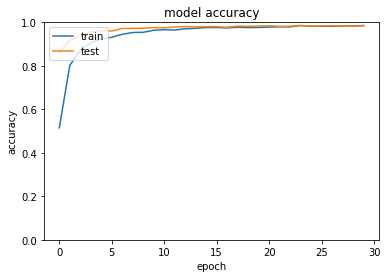

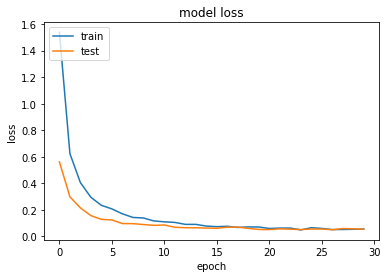

In [13]:
%matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0,1))
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
"""nn_pred = model.predict(X_test)
nn_pred = [np.argmax(nn_pred[i]) for i in range(len(nn_pred))]
np.savetxt('y_pred.txt', nn_pred, fmt="%d")
print(np.unique(nn_pred,return_counts=True))"""


'nn_pred = model.predict(X_test)\nnn_pred = [np.argmax(nn_pred[i]) for i in range(len(nn_pred))]\nnp.savetxt(\'y_pred.txt\', nn_pred, fmt="%d")\nprint(np.unique(nn_pred,return_counts=True))'

In [15]:
"""new_nn_pred = []   
preds = {}
for i in range(298):
    preds[i] = []
    preds[i].extend(nn_pred[10*i:10*i+10])
for x in preds.values():
    count = Counter(x)
    new_nn_pred.append(count.most_common()[0][0])
np.savetxt('y_pred.txt', new_nn_pred, fmt="%d")"""

'new_nn_pred = []   \npreds = {}\nfor i in range(298):\n    preds[i] = []\n    preds[i].extend(nn_pred[10*i:10*i+10])\nfor x in preds.values():\n    count = Counter(x)\n    new_nn_pred.append(count.most_common()[0][0])\nnp.savetxt(\'y_pred.txt\', new_nn_pred, fmt="%d")'

## Regression Logistique ftw

In [16]:
reg = LogisticRegression()
reg.fit(X_train, y_train)
reg_pred = reg.predict(X_test)

## SVM

In [17]:
from sklearn.svm import SVC
#X = np.concatenate([X_train,X_dev])
#y = np.concatenate([y_train,y_dev])
X,y = X_train, y_train
X,y = unison_shuffled_copies(X, y)
svm = SVC(probability=True)
svm.fit(X,y)



SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## XGBoost 

In [18]:
import os
mingw_path = 'C:\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost as xgb

gbm = xgb.XGBClassifier()
X,y = X_train, y_train
X,y = unison_shuffled_copies(X, y)
    
print(X.shape,y.shape)
gbm.fit(X, y)

(8711, 150) (8711,)


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

## Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 500)
clf.fit(X_train, y_train)
rf_pred = clf.predict_proba(X_test)

## Mix results with probas

In [25]:
svm_pred = svm.predict_proba(X_test)
reg_pred = reg.predict_proba(X_test)
nn_pred = model.predict_proba(X_test)
xgb_pred = gbm.predict_proba(X_test)

2880/2980 [===========================>..] - ETA: 0s

In [32]:
new_pred = []
for i in range(298):
    preds = np.concatenate([svm_pred[10*i:10*(i+1)], reg_pred[10*i:10*(i+1)], nn_pred[10*i:10*(i+1)], xgb_pred[10*i:10*(i+1)], rf_pred[10*i:10*(i+1)]])
    probas = np.zeros(15)
    for j in range(50):
        for k in range(15):
            probas[k] += preds[j][k]
    new_pred.append(np.argmax(probas))
np.savetxt('y_pred.txt', new_pred, fmt="%d")
print(np.unique(new_pred,return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14], dtype=int64), array([23, 18, 10, 18, 19, 20, 29, 27, 20, 22,  9, 22, 20,  9, 32], dtype=int64))
